# Decoding mouse quartile from trial sequences

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
# from postprocessing_functions import define_trial_types, bin_sequence, decoder

from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [4]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per session

In [122]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

## Get sequence of trial modes

In [123]:
plot = False
target_length = 3

all_sequences = pd.DataFrame(columns=['session', 'mouse_name', 'trial_type', 'cluster', 'bin'])
for s, session in enumerate(trial_clusters['session'].unique()):

    # Get session data and order trials
    session_data = trial_clusters.loc[trial_clusters['session']==session]
    session_data = session_data[['session', 'mouse_name', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # Bin 
    n_trials = len(session_data)
    # Assign bin index: split into 10 parts
    bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
    session_data['bin'] = bin_indices
      
    all_sequences = pd.concat([all_sequences, session_data[['session', 'mouse_name',
                                                            'trial_type', 'cluster', 'bin']]], ignore_index=True)


In [124]:
fractions = all_sequences.groupby(['session', 'mouse_name',
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
fractions

,session,mouse_name,bin,cluster,fraction
5,03063955-2523-47bd-ae57-f7489dd40f15,SWC_038,0,0,0.097561
25,032452e9-1886-449d-9c13-0f192572e19f,SWC_053,0,0,0.074074
44,034e726f-b35f-41e0-8d6c-a22cc32391fb,CSHL045,0,0,0.128205
65,03d9a098-07bf-4765-88b7-85f8d8f620cc,UCLA014,0,0,0.089947
81,0802ced5-33a3-405e-8336-b65ebc5cb07c,ZFM-02373,0,0,0.269504
...,...,...,...,...,...
4108,fb70ebf7-8175-42b0-9b7a-7c6e8612226e,CSHL058,2,6,0.441315
4128,fc14c0d6-51cf-48ba-b326-56ed5a9420c3,SWC_052,2,6,0.286550
4153,fc43390d-457e-463a-9fd4-b94a0a8b48f5,NYU-47,2,6,0.094241
4171,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,CSH_ZAD_025,2,6,0.203175


In [125]:
design_df = fractions.pivot(index=['mouse_name', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)
var_names = design_df.keys()[2:]
final_matrix = design_df[var_names]

([<matplotlib.axis.XTick at 0x7b0feca97340>], [Text(0, 0, '0')])

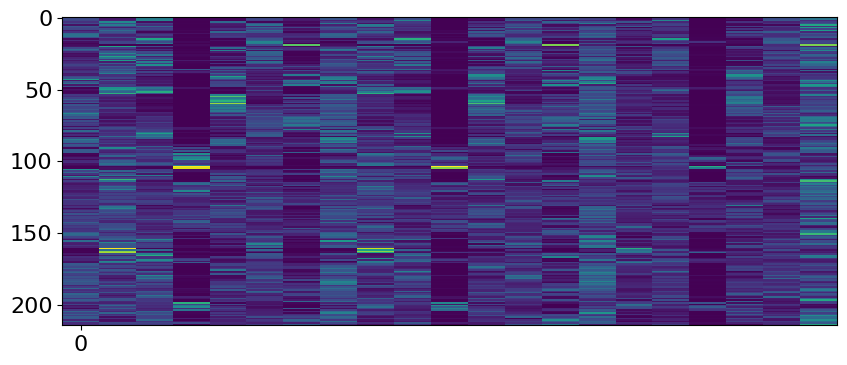

In [126]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

## Get learning time

In [127]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

/tmp/ipykernel_24863/3884704591.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


Text(0, 0.5, 'Number of mice')

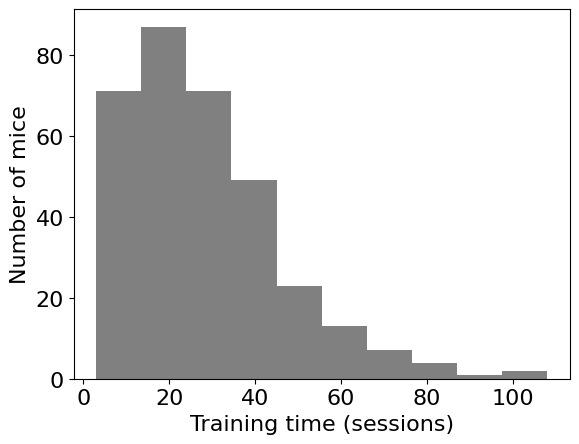

In [128]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
df = new_df.merge(learning_times, on='mouse_name')
a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

plt.rcParams.update({'font.size': 16})
plt.hist(full_learning['training_time'], color='grey')
plt.xlabel('Training time (sessions)')
plt.ylabel('Number of mice')

In [129]:
merged_df =new_df.merge(learning_times_new, on=['mouse_name'])
merged_df['quartile'] = pd.qcut(merged_df['training_time'], q=[0, .25, .5, .75, 1], labels=[1, 2, 3, 4])
# merged_df['quartile'] = pd.qcut(merged_df['training_time'], q=[0, .33, .66, 1], labels=[1, 2, 3])
# merged_df['quartile'] = pd.qcut(merged_df['training_time'], q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
mat = design_df.droplevel(1, axis=1).merge(merged_df, on=['mouse_name', 'session'])
mat = mat.drop(columns=['index', 'training_time', 'mouse_name', 'session'])

## Decode quartile

In [130]:
def plot_cm(decoding_result, trial_epochs, control=False):
    """
    PLOT RESULTS
    """

    # -- Confusion Matrix
    # labels = trial_epochs

    # Results on original model
    plt.rc('font', size=12) 
    plt.figure(figsize=[6.2, 5.2])
    hmap = sns.color_palette("mako", as_cmap=True)
    data = decoding_result.loc[decoding_result['shuffle'] == 0]
    sns.heatmap(data['confusion_matrix'].mean(), annot=True, square=True,
        yticklabels=trial_epochs, xticklabels=trial_epochs, 
        cmap= hmap, vmin=0, vmax=1, fmt=".2f") 

    # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig('full_cm.svg',dpi=500)
    plt.show()
    print('F1 results', data['f1'].mean())

    if control:
        # Results from shuffled model
        plt.rc('font', size=12) 
        plt.figure(figsize=[6.2, 5.2])
        data = decoding_result.loc[decoding_result['shuffle'] >0]
        sns.heatmap(data['confusion_matrix'].mean(), annot=True, square=True,
            yticklabels=trial_epochs, xticklabels=trial_epochs, 
            cmap= hmap, vmin=0, vmax=1, fmt=".2f")

        # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        plt.xticks(rotation = 90)
        plt.yticks(rotation = 0)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        print('F1 shuffled results',  data['f1'].mean())


def plot_f1(decoding_result):
    # -- F1 score per model, original and shuffled
    data = decoding_result.copy()
    data['f1'] = data['f1'].astype(float)

    data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
    data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
    data = data.rename(columns={'shuffle': 'Dataset'})

    plt.rc('font', size=12) 
    plt.figure(figsize=[4.5, 4])
    sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
    sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
    plt.ylim([0,1])
    plt.ylabel('Accuracy score (F1)')
    plt.legend(bbox_to_anchor=(1.05, 1))
    sns.despine(top=True, right=True)
    #plt.savefig('violin.svg',dpi=500)
    

In [131]:
shufflings = 10  #shuffling
model = GaussianNB()
# model = RandomForestClassifier(max_depth=2, random_state=0)
model = RandomForestClassifier(random_state=42)

In [132]:
    var = 'quartile'    
    use_mat = mat.copy() # test using all mice


In [133]:
    """
    RUN MODEL
    """

    # Generate random states for each iteration with a fixed seed
    # Loop over iterations of random draws of mice
    # Create empty dataframes to save results
    decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    use_mat = mat.copy() # test using all mice

    # Find minimum number of samples per label
    labels = np.array(use_mat[var])
    labels_nr = np.arange(len(use_mat[var]))
    min_freq = np.min(use_mat[var].value_counts())

    # Randomly select N mice from each quartile to equalize classes
    use_index = np.empty(0, dtype=int)
    for j, epoch in enumerate(np.unique(labels)):
        use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                                min_freq, replace=False)])

    new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
            
    # -- ORIGINAL DATASET

    dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
    y_pred = np.zeros(len(new_mat), dtype=int) 
    exog = new_mat[new_mat.columns.difference([var])]
    endog = new_mat.loc[:, var].copy()
    # endog[:] = replace_func(endog)

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'shuffle'] = 0

    decoding_result = pd.concat([decoding_result, dec_result])

    # -- SHUFFLED DATASET 
    shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(new_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])

/tmp/ipykernel_24863/3179701473.py:58: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(shuffle_endog.values)
/tmp/ipykernel_24863/3179701473.py:58: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(shuffle_endog.values)
/tmp/ipykernel_24863/3179701473.py:58: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(shuffle_endog.values)
/tmp/ipykernel_24863/3179701473.py:58: U

Shuffling 10 of 10


/tmp/ipykernel_24863/3179701473.py:58: UserWarning: you are shuffling a 'Categorical' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(shuffle_endog.values)


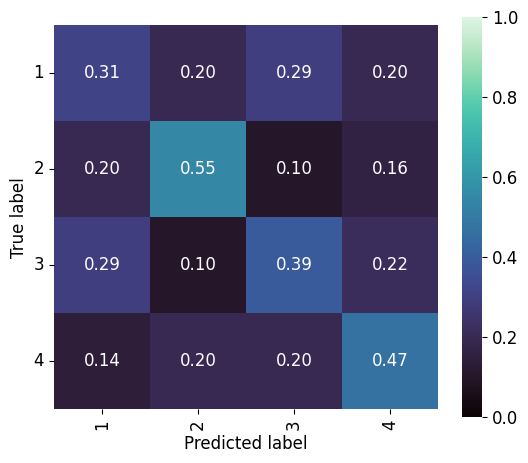

F1 results 0.43137254901960786


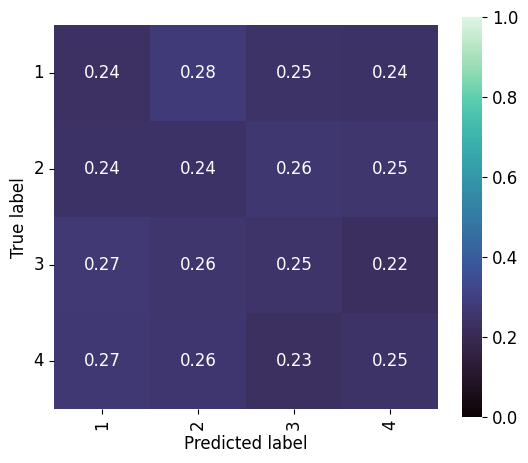

F1 shuffled results 0.2416666666666667


/tmp/ipykernel_24863/229405456.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1))


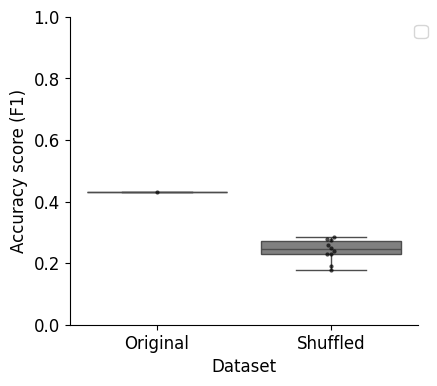

In [134]:
    plot_cm(decoding_result, ['1', '2', '3', '4'], control=True)
    # plot_cm(decoding_result, ['1', '2', '3', '4', '5'], control=True)
    plot_f1(decoding_result)

## Vizualize results

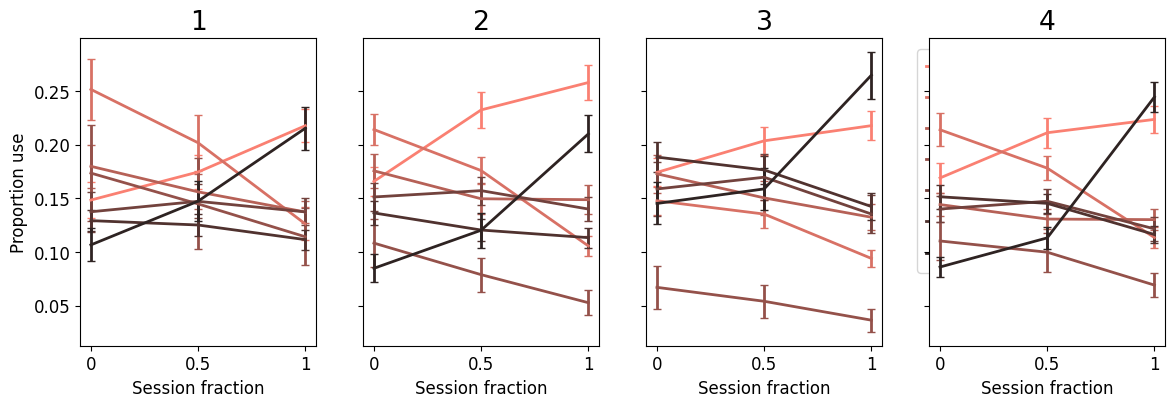

In [136]:
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())


mice_quantiles = design_df[['mouse_name', 'session']].droplevel(1, axis=1).merge(merged_df, on=['mouse_name', 'session'])
use_fractions = fractions.merge(mice_quantiles[['session', 'mouse_name', 'quartile']])
quantiles = mice_quantiles['quartile'].unique().sort_values()

fig, axs = plt.subplots(1, len(quantiles), sharex=True, sharey=True, figsize=(14, 4))
for q, quantile in enumerate(quantiles):

    # Group by bin and cluster, and compute mean and SEM
    summary = use_fractions.loc[use_fractions['quartile']==quantile].groupby(['bin', 
                                                                           'cluster'])['fraction'].agg(['mean', 'sem']).reset_index()
    # Ensure correct types
    summary['bin'] = summary['bin'].astype(float)
    summary['cluster'] = summary['cluster'].astype(float)

    # Prepare plot
    plt.rc('font', size=16)

    clusters = sorted(summary['cluster'].unique())

    # Plot one line with error bars for each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = summary[summary['cluster'] == cluster]
        axs[q].errorbar(
            cluster_data['bin'], 
            cluster_data['mean'], 
            yerr=cluster_data['sem'], 
            label=f'Trial mode {int(cluster)}',
            color=my_cmap(i),
            capsize=3,
            linewidth=2
        )

    # Customize axes
    # axs[quantile].set_xticks([0, 1, 2, 3, 4], [0, .25, .5, .75, 1])
    axs[q].set_xticks([0, 1, 2], [0, .5, 1])
    # axs[phenotype].set_xticks(sorted(fractions['bin'].unique()))
    # axs[phenotype].set_xticklabels([str(int(b)) for b in sorted(fractions['bin'].unique())])
    axs[q].set_xlabel('Session fraction')
    axs[q].set_title(str(quantile))
axs[0].set_ylabel('Proportion use')
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
# plt.tight_layout()
plt.show()

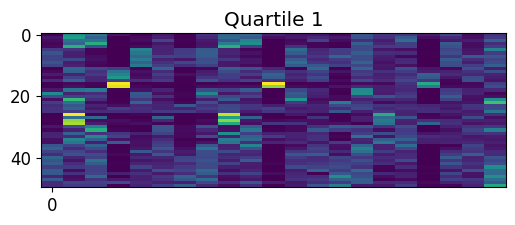

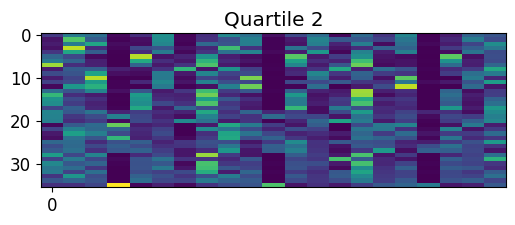

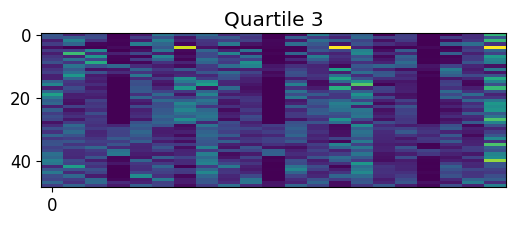

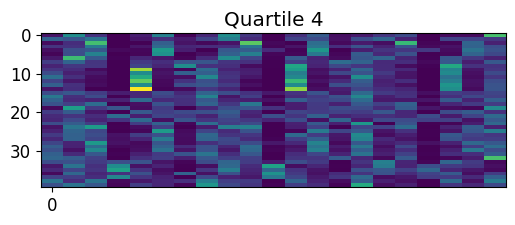

In [87]:
for q, quartile in enumerate([1, 2, 3, 4]):
    indices = np.where(use_mat[var]==quartile)[0]
    data = np.array(final_matrix)[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Quartile ' + str(quartile))
    plt.show()

In [88]:
fractions = all_sequences.groupby(['session', 'mouse_name'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['cluster'])
fractions

,session,mouse_name,cluster,fraction
1448,ff96bfe1-d925-4553-94b5-bf8297adf259,ibl_witten_26,0,0.059952
1267,e9fc0a2d-c69d-44d1-9fa3-314782387cae,ibl_witten_29,0,0.099057
497,57b5ae8f-d446-4161-b439-b191c5e3e77b,CSHL059,0,0.096774
950,9eec761e-9762-4897-b308-a3a08c311e69,DY_020,0,0.237517
188,22e04698-b974-4805-b241-3b547dbf37bf,SWC_052,0,0.163743
...,...,...,...,...
496,57b5ae8f-d446-4161-b439-b191c5e3e77b,CSHL059,6,0.106452
948,9e9c6fc0-4769-4d83-9ea4-b59a1230510e,ZFM-01576,6,0.117647
1264,e9fc0a2d-c69d-44d1-9fa3-314782387cae,ibl_witten_29,6,0.424528
500,58b1e920-cfc8-467e-b28b-7654a55d0977,ibl_witten_29,6,0.285912


In [89]:
design_df = fractions.pivot(index=['mouse_name', 'session'], columns=['cluster'], values='fraction').reset_index().fillna(0)
var_names = design_df.keys()[2:]
final_matrix = design_df[var_names]

/tmp/ipykernel_24863/509127702.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/tmp/ipykernel_24863/509127702.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/tmp/ipykernel_24863/509127702.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice 

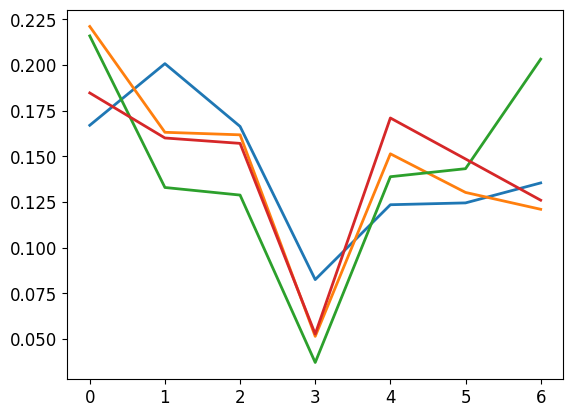

In [90]:
# fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1, 2, 3, 4]):
    new_df = final_matrix.stack(0).unstack()
    use_data = new_df.iloc[np.where(mat['quartile']==quartile)]
    sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    plt.plot(np.nanmean(use_data, axis=0), linewidth=2)

/tmp/ipykernel_24863/3414250144.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/tmp/ipykernel_24863/3414250144.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/tmp/ipykernel_24863/3414250144.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choi

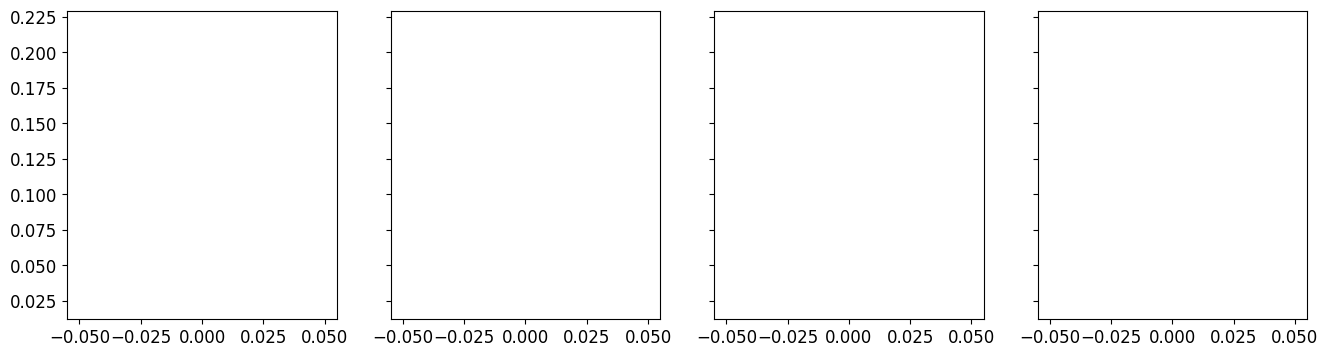

In [27]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1, 2, 3, 4]):
    new_df = final_matrix.stack(0).unstack()
    use_data = new_df.iloc[np.where(mat['quartile']==quartile)]
    sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    axs[q].plot(np.nanmean(use_data[0], axis=0), linewidth=2, label='Trial mode 0')
    axs[q].plot(np.nanmean(use_data[1], axis=0), linewidth=2, label='Trial mode 1')
    axs[q].plot(np.nanmean(use_data[2], axis=0), linewidth=2, label='Trial mode 2')
    axs[q].plot(np.nanmean(use_data[3], axis=0), linewidth=2, label='Trial mode 3')
    axs[q].plot(np.nanmean(use_data[4], axis=0), linewidth=2, label='Trial mode 4')
    axs[q].plot(np.nanmean(use_data[5], axis=0), linewidth=2, label='Trial mode 5')
    axs[q].plot(np.nanmean(use_data[6], axis=0), linewidth=2, label='Trial mode 6')

In [42]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'

trials_filename = str(results_path + 'cluster_per_trial_part_info03-21-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')

In [43]:
new_clusters = trial_clusters.merge(merged_df[['mouse_name', 'session']].drop_duplicates(), on=['mouse_name', 'session'])

In [44]:
feedback = pd.DataFrame(trial_clusters.groupby(['mouse_name', 'session'])[['feedback','contrast', 'block']].mean()).reset_index()
timings = pd.DataFrame(trial_clusters.groupby(['mouse_name', 'session'])[['reaction', 'response','elongation']].median()).reset_index()

In [45]:
final = timings.merge(merged_df, on=['mouse_name', 'session'])


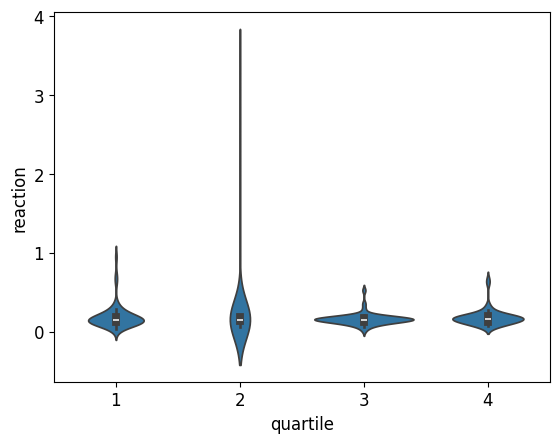

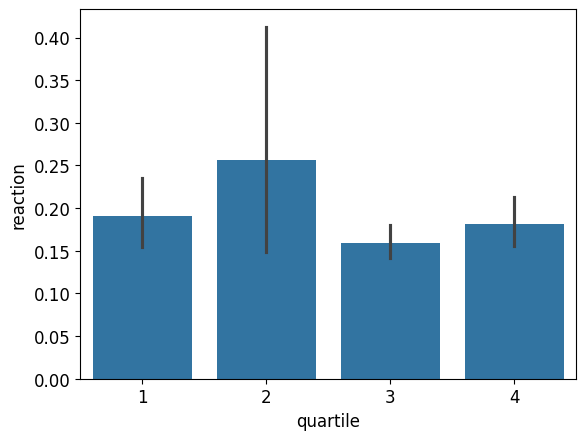

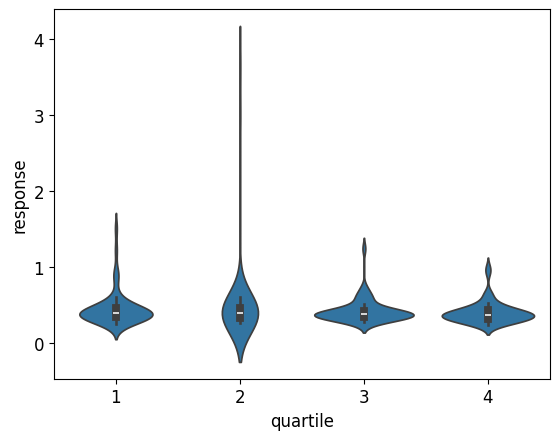

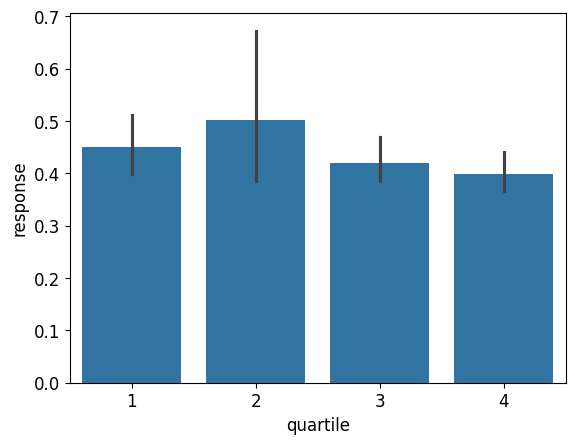

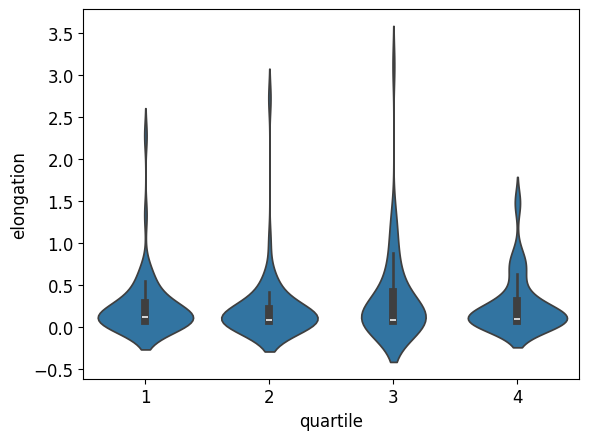

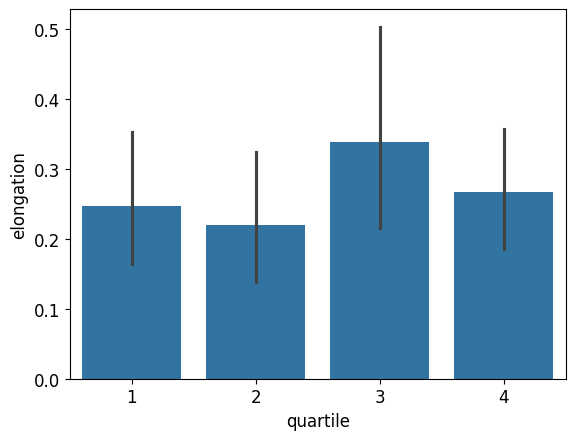

In [46]:
sns.violinplot(x='quartile', y='reaction', data=final)
plt.show()
sns.barplot(x='quartile', y='reaction', data=final)
plt.show()
sns.violinplot(x='quartile', y='response', data=final)
plt.show()
sns.barplot(x='quartile', y='response', data=final)
plt.show()
sns.violinplot(x='quartile', y='elongation', data=final)
plt.show()
sns.barplot(x='quartile', y='elongation', data=final)
plt.show()

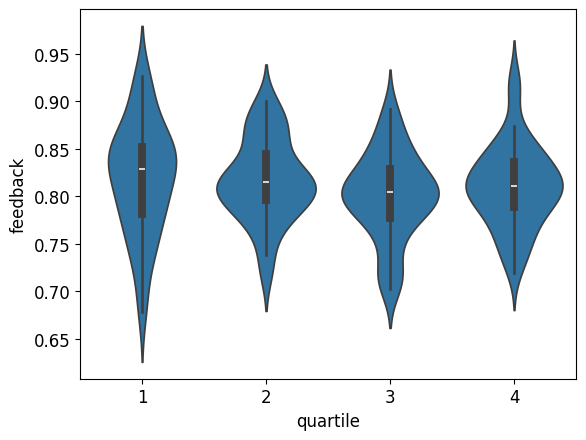

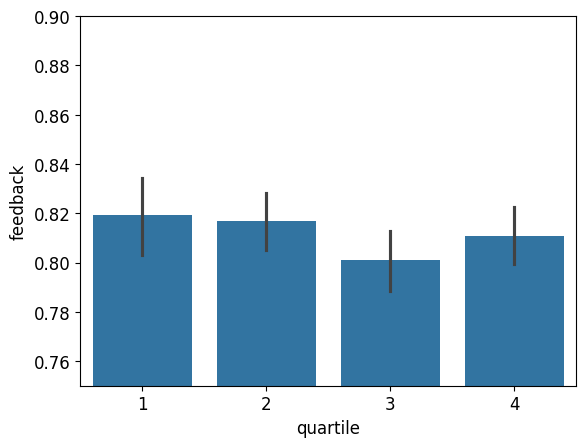

In [48]:
final = feedback.merge(merged_df, on=['mouse_name', 'session'])

sns.violinplot(x='quartile', y='feedback', data=final)
plt.show()
sns.barplot(x='quartile', y='feedback', data=final)
plt.ylim([.75, .9])
plt.show()


In [ ]:
part_trials_df = trials_cluster.merge(trial_clusters, on=['mouse_name', 'sample', 'cluster'])

In [ ]:
use_states = parts_clusters.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')
use_parts_trials = part_trials_df.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')

In [227]:
use_parts_trials = trial_clusters.merge(merged_df, on=['mouse_name', 'session'])

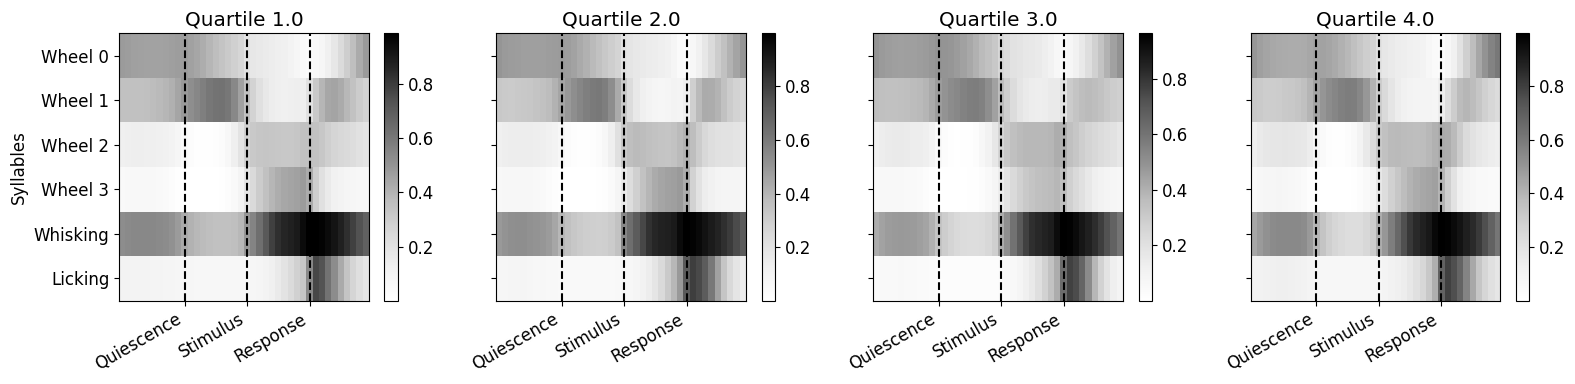

In [230]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

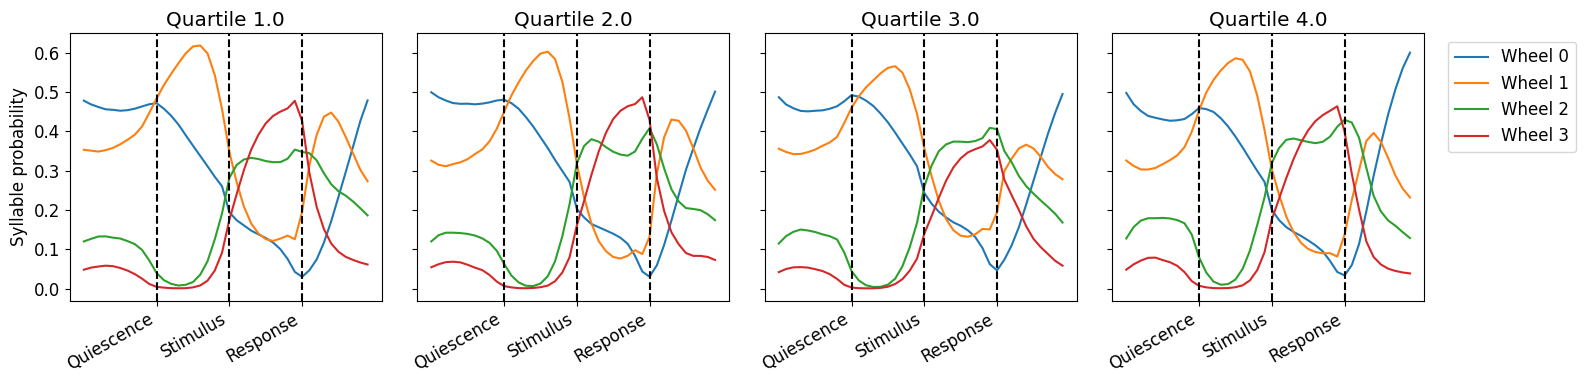

In [231]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()

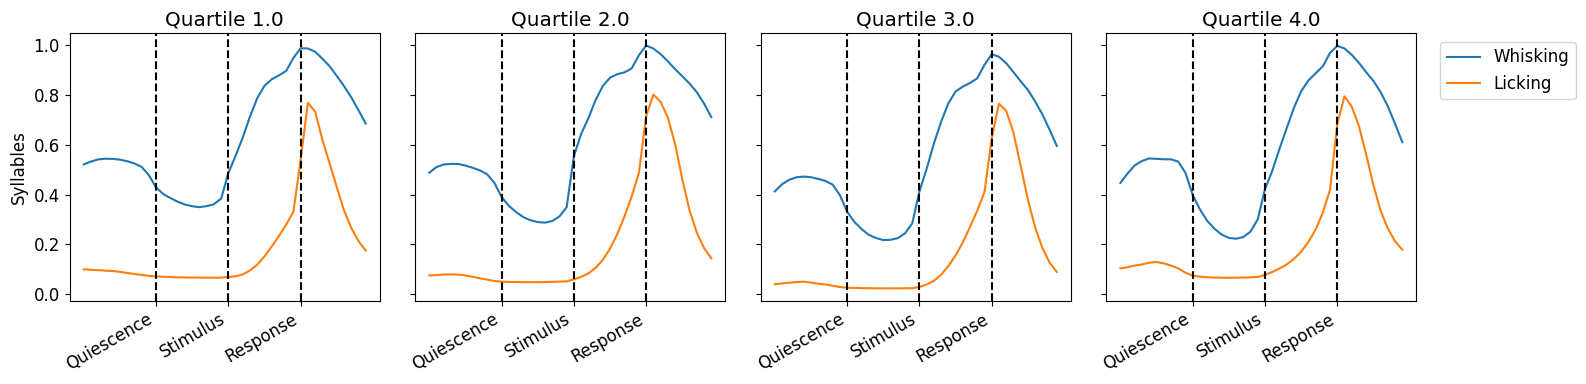

In [233]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()